# Content-based recommendation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Read in data and prepare for recommendation system

In [3]:
df_path = '/Users/linwang/Documents/AmaRec/'
df = pd.read_csv(df_path + 'data/processed/data_clean_kmeanlabel.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451648 entries, 0 to 451647
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   customer_id            451648 non-null  int64 
 1   review_id              451648 non-null  object
 2   product_id             451648 non-null  object
 3   review_date            451648 non-null  object
 4   star_rating            451648 non-null  int64 
 5   raw_product_title      451648 non-null  object
 6   raw_review_headline    451646 non-null  object
 7   raw_review_body        451530 non-null  object
 8   product_title          451647 non-null  object
 9   review_headline        451033 non-null  object
 10  review_body            450864 non-null  object
 11  product cluster label  451648 non-null  int64 
 12  cluster_label          451648 non-null  object
dtypes: int64(3), object(10)
memory usage: 44.8+ MB


In [4]:
df.groupby('product cluster label')['star_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
product cluster label,,,,,,,,
0,10226.0,4.310483,1.205822,1.0,4.0,5.0,5.0,5.0
1,5815.0,4.131384,1.372216,1.0,4.0,5.0,5.0,5.0
2,11572.0,4.519703,1.011152,1.0,5.0,5.0,5.0,5.0
3,311730.0,4.245241,1.236134,1.0,4.0,5.0,5.0,5.0
4,24924.0,4.296903,1.171265,1.0,4.0,5.0,5.0,5.0
5,32429.0,4.171451,1.304421,1.0,4.0,5.0,5.0,5.0
6,12799.0,4.393078,1.105521,1.0,4.0,5.0,5.0,5.0
7,24320.0,4.331414,1.190910,1.0,4.0,5.0,5.0,5.0
8,17833.0,4.272416,1.218792,1.0,4.0,5.0,5.0,5.0


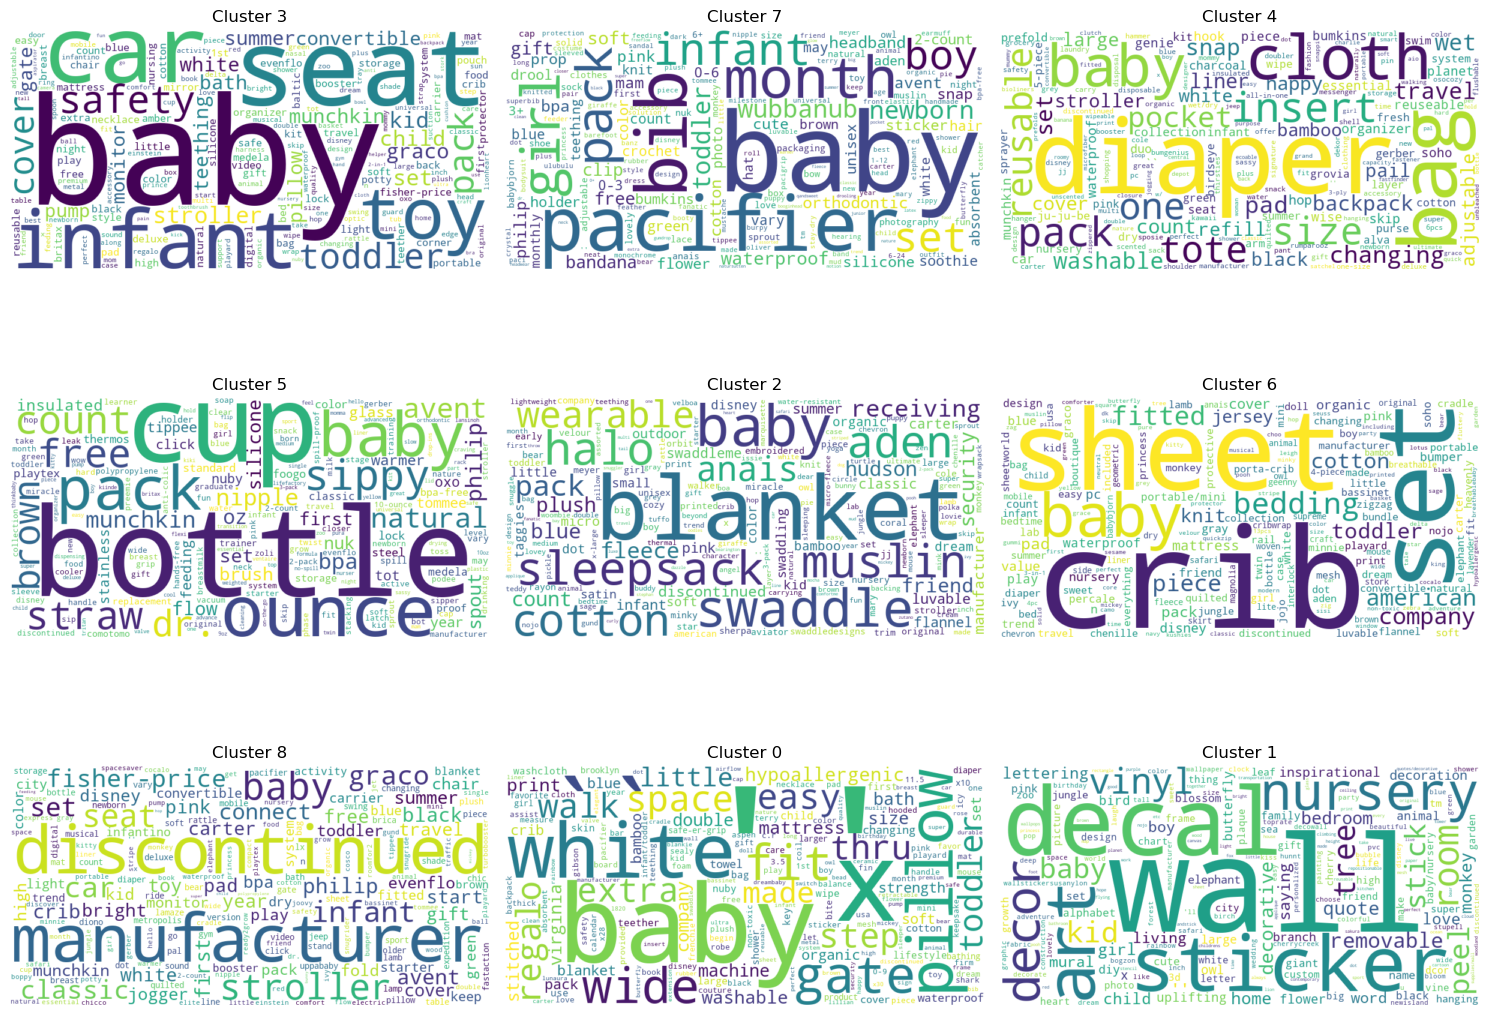

In [6]:
cluster_labels = df['product cluster label'].unique()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, cluster_label in enumerate(cluster_labels):
    df_text = df[df['product cluster label'] == cluster_label]['product_title']
    combined_text = ' '.join(df_text.astype(str))
    word_frequencies = Counter(combined_text.split())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_label}')
    ax.axis('off')

if len(cluster_labels) < len(axes):
    fig.delaxes(axes[len(cluster_labels)])

plt.tight_layout()
plt.savefig('kmeans-wordcloud-n9.png')
plt.show()

### Remove products contain names 'discontinued'

In [4]:
df = df[~df['product_title'].astype(str).str.contains('discontinued', na=False)]

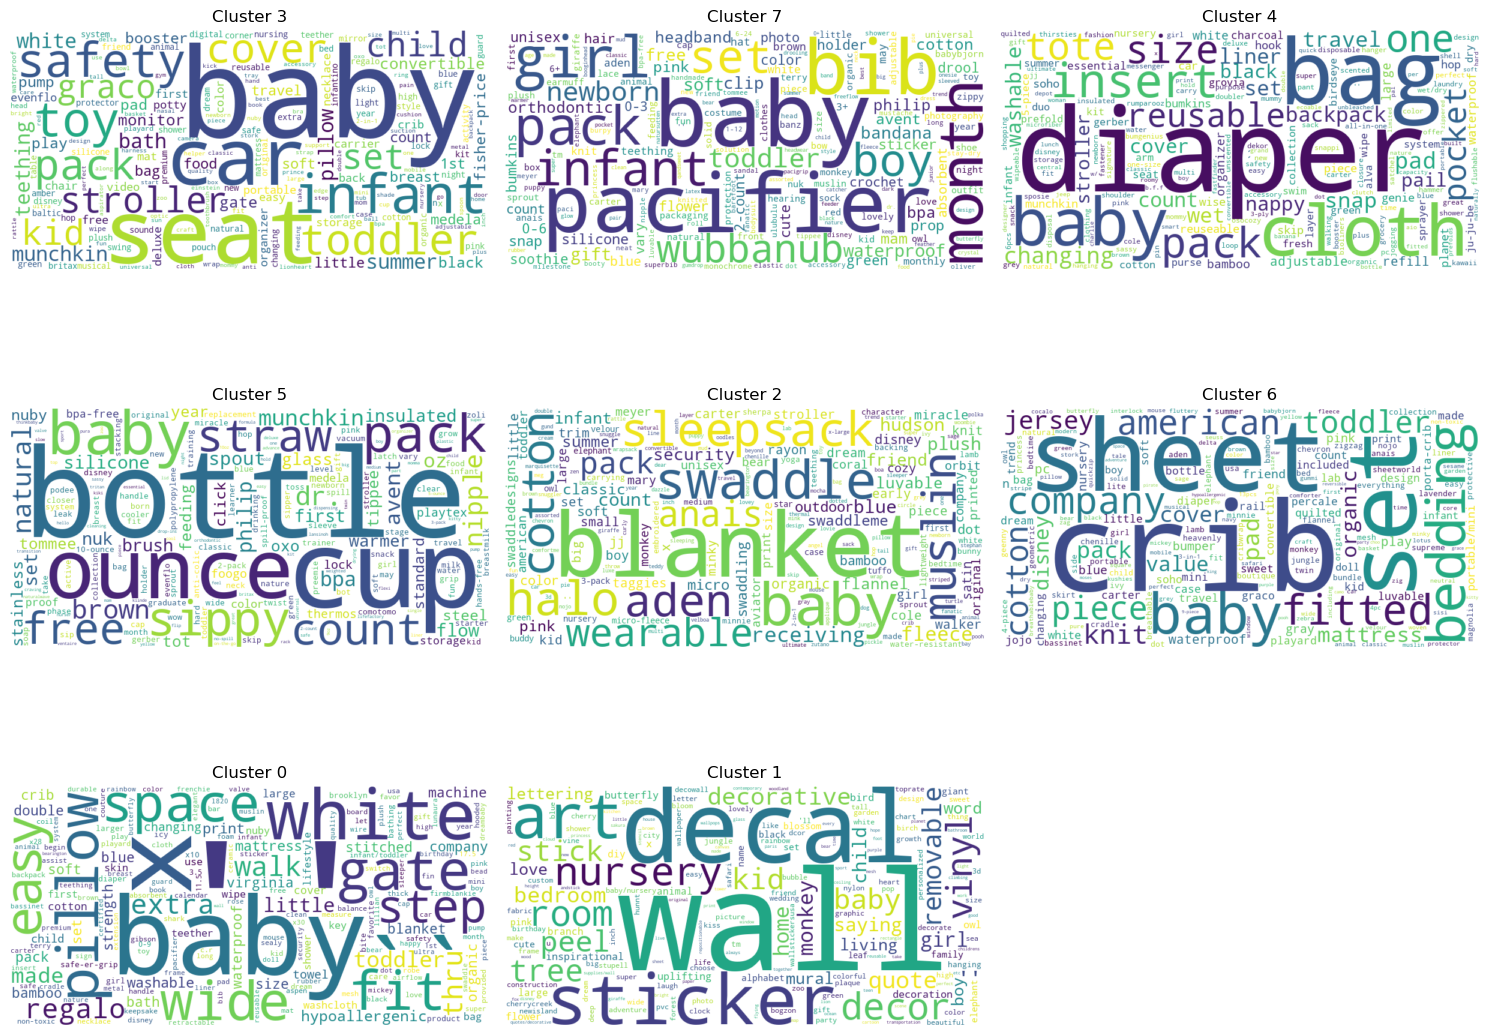

In [9]:
cluster_labels = df['product cluster label'].unique()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, cluster_label in enumerate(cluster_labels):
    df_text = df[df['product cluster label'] == cluster_label]['product_title']
    combined_text = ' '.join(df_text.astype(str))
    word_frequencies = Counter(combined_text.split())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_label}')
    ax.axis('off')

if len(cluster_labels) < len(axes):
    fig.delaxes(axes[len(cluster_labels)])

plt.tight_layout()
plt.savefig('kmeans-wordcloud-n8.png')
plt.show()

## Randomly select 1000 products from each cluster (8000 in total)

In [5]:
df_sample = df.groupby('product cluster label').sample(1000, random_state=42)
n_cust = df_sample['customer_id'].nunique()
n_prod = df_sample['product_id'].nunique()
print(f'unique number of customers: {n_cust}')
print(f'unique number of products: {n_prod}')

unique number of customers: 7774
unique number of products: 5185


## Content-based recommendation

## For users who have interacted with products

### Find the cluster labels of products to be recommended

In [11]:
customer_id = 10134
user_data = df_sample[df_sample['customer_id']==customer_id][['star_rating','product cluster label']]

# get all cluster labels where the user hasn't interacted with the product, OR the user's interaction with the product has a rating below 4
all_labels = set(df_sample['product cluster label'].unique().astype(int))

if not user_data[user_data['star_rating'] > 3]['product cluster label'].empty:
  good_labels = user_data[user_data['star_rating']>3]['product cluster label'].to_numpy().astype(int)
  rec_label = list(all_labels.difference(good_labels))
else:
  rec_label = list(all_labels)


### Select top-rated producted from the identified clusters

In [15]:
product_mean_rating = df_sample.groupby(['product_id', 'product_title'])['star_rating'].mean()
product_mean_rating = product_mean_rating.rename('mean_star_rating')
df_merge = df_sample.merge(product_mean_rating, on='product_title',how='left')

n = 10//len(rec_label) #calcualte n for each cluster, such that the number of recommended products is < 10
top_n_products = df_merge.groupby('product cluster label').apply(lambda x: x.nlargest(n, 'mean_star_rating')).reset_index(drop=True)
recomd_prod = top_n_products[top_n_products['product cluster label'].isin(rec_label)]
for _, row in recomd_prod.iterrows():
      print("Product ID:", row['product_id'])
      print("Product Title:", row['product_title'])

Product ID: B0030U4VQ6
Product Title: e-lock light switch guard locking switch `` '' `` ''
Product ID: B00GW0C1PO
Product Title: kitchen heart home vinyl wall decal quote saying word art decor lettering vinyl wall art inspirational uplifting
Product ID: B00B1M2N88
Product Title: halo early walker sleepsack wearable blanket micro fleece
Product ID: B002UHKL3C
Product Title: pampers airwave venting system stage ounce clear single pack
Product ID: B00RM9OXM8
Product Title: soho collection grand tribeca piece diaper tote bag set limited time offer
Product ID: B000056JMU
Product Title: playtex count bottle liner drop-ins
Product ID: B00AHJYERY
Product Title: owl wonderland piece baby crib bedding set bumper coco amp company
Product ID: B002662DDI
Product Title: baby buddy gift pack blue


## For new users who have not interacted with products

In [16]:
rec_label = list(set(df_sample['product cluster label'].unique().astype(int)))

product_mean_rating = df_sample.groupby(['product_id', 'product_title'])['star_rating'].mean()
product_mean_rating = product_mean_rating.rename('mean_star_rating')
df_merge = df_sample.merge(product_mean_rating, on='product_title',how='left')

n = 10//len(rec_label) #calcualte n for each cluster, such that the number of recommended products is < 10
top_n_products = df_merge.groupby('product cluster label').apply(lambda x: x.nlargest(n, 'mean_star_rating')).reset_index(drop=True)
recomd_prod = top_n_products[top_n_products['product cluster label'].isin(rec_label)]
for _, row in recomd_prod.iterrows():
      print("Product ID:", row['product_id'])
      print("Product Title:", row['product_title'])

Product ID: B0030U4VQ6
Product Title: e-lock light switch guard locking switch `` '' `` ''
Product ID: B00GW0C1PO
Product Title: kitchen heart home vinyl wall decal quote saying word art decor lettering vinyl wall art inspirational uplifting
Product ID: B00B1M2N88
Product Title: halo early walker sleepsack wearable blanket micro fleece
Product ID: B002UHKL3C
Product Title: pampers airwave venting system stage ounce clear single pack
Product ID: B00RM9OXM8
Product Title: soho collection grand tribeca piece diaper tote bag set limited time offer
Product ID: B000056JMU
Product Title: playtex count bottle liner drop-ins
Product ID: B00AHJYERY
Product Title: owl wonderland piece baby crib bedding set bumper coco amp company
Product ID: B002662DDI
Product Title: baby buddy gift pack blue


### Use Aprioi algorithm to find out the items that were bought together frequently

In [16]:
# Filter the DataFrame for non-zero star_ratings
filtered_df = df_sample[df_sample['star_rating'] > 0]
result = filtered_df.groupby('customer_id')['raw_product_title'].unique()
result_list = result.tolist()

# TransactionEncoder converts transaction data into a one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit_transform(result_list)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [37]:

# Applying Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

# Generating association rules
association_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)

# Printing frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Printing association rules
print("\nAssociation Rules:")
print(association_rules)

TypeError: 'DataFrame' object is not callable